# Chat with your own video with Azure OpenAI GPT-4 Turbo Vision and Azure AI Spatial Analysis Video Retrieval

## Checklist usecase: from video to text

This solution accelerator presents a detailed framework for analyzing videos, leveraging Azure OpenAI GPT4-Vision with Video Enhancements technology.
It's a crucial resource for businesses across a range of industries, including marketing, media, education, manufacturing, healthcare, and retail.

**Azure AI Spatial Analysis Video Retrieval APIs** are part of Azure AI Vision and enable developers to create an index, add documents (videos and images) to it, and search with natural language. Developers can define metadata schemas for each index and ingest metadata to the service to help with retrieval. Developers can also specify what features to extract from the index (vision, speech) and filter their search based on features.

> All credits to: https://github.com/Azure/gen-cv/blob/main/video/README.md

Documentation:
- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/how-to/video-retrieval
- https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/reference-video-search
- https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/gpt-with-vision


> Note: Video retrieval using vectorization is preview (version 4.0 preview)

In [3]:
import base64
import cv2
import datetime
import io
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
import pandas as pd
import requests
import sys
import time

from azure.core.credentials import AzureSasCredential
from azure.storage.blob import BlobClient
from docx import Document
from dotenv import load_dotenv
from IPython.display import Video, Markdown, HTML, FileLink
from moviepy.editor import VideoFileClip
from urllib.parse import quote

## 1. Setup

In [2]:
load_dotenv("azure.env")

# 1. Azure OpenAI
AOAI_KEY = os.getenv("AOAI_KEY")
AOAI_ENDPOINT = os.getenv("AOAI_ENDPOINT")

# 2. Azure AI Vision
AZURE_CV_KEY = os.getenv("AZURE_CV_KEY")
AZURE_CV_ENDPOINT = os.getenv("AZURE_CV_ENDPOINT")

# 3. Azure Storage Account
# Check the validatity date and "Add, Create, Write, Delete and List" permissions for the SAS Token
AZURE_SAS_TOKEN = os.getenv("AZURE_SAS_TOKEN")
AZURE_STORAGE_ACCOUNT = os.getenv("AZURE_STORAGE_ACCOUNT")
# Container to store the videos
AZURE_STORAGE_CONTAINER = os.getenv("AZURE_STORAGE_CONTAINER")

In [4]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]
OpenAI version: 1.10.0


In [5]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 06-Feb-2024 15:27:54


In [6]:
pd.set_option("display.max_colwidth", False)

### GPT-4 Turbo with Vision model

In [7]:
GPT_4V_DEPLOYMENT = "gpt-4TurboVision"  # Your GPT4 Turbo Vision deployed model

In [8]:
GPT_4V_ENDPOINT = f"{AOAI_ENDPOINT}/openai/deployments/{GPT_4V_DEPLOYMENT}\
/extensions/chat/completions?api-version=2023-12-01-preview"

### Directories

In [9]:
AZURE_STORAGE_PATH = "checklist/"  # Directory to create into your blob storage

VIDEO_DIR = "videos"
VIDEO_INDEX = f"list-{str(datetime.datetime.today().strftime('%d%b%Y-%H%M%S'))}"

In [10]:
print(f"Index to create: {VIDEO_INDEX}")

Index to create: list-06Feb2024-152756


## 2. Helper functions

In [11]:
def upload_file_to_blob(blob_name: str, source_dir=VIDEO_DIR, file_extension: str = ""):
    """
    Uploads a file to Azure Blob Storage.

    Args:
        blob_name (str): The name of the blob (file) to be uploaded.
        source_dir (str, optional): The directory of the source file. Defaults to VIDEO_DIR.
        file_extension (str, optional): The file extension (including the dot, e.g., '.mp4') to
        be appended to blob_name. Defaults to ''.

    Returns:
        str: The URL of the uploaded blob.

    """
    account_url = "https://{}.blob.core.windows.net/".format(AZURE_STORAGE_ACCOUNT)

    full_blob_name = os.path.join(AZURE_STORAGE_PATH, blob_name + file_extension)
    encoded_blob_name = quote(full_blob_name)  # URL-encode the full_blob_name

    blob_client = BlobClient(
        account_url=account_url,
        container_name=AZURE_STORAGE_CONTAINER,
        blob_name=full_blob_name,
        credential=AzureSasCredential(AZURE_SAS_TOKEN),
        max_block_size=1024 * 1024 * 4,  # 4 MiB
        max_single_put_size=1024 * 1024 * 16,  # 16 MiB
    )

    with open(
        file=os.path.join(source_dir, blob_name + file_extension), mode="rb"
    ) as data:
        blob_client.upload_blob(data=data, overwrite=True, max_concurrency=2)

    return account_url + AZURE_STORAGE_CONTAINER + "/" + encoded_blob_name


def local_videos_to_azure_blob(file_path, video_dir=VIDEO_DIR):
    """
    Upload local videos to Azure Storage Account
    """
    video_path = os.path.join(video_dir, file_path)

    # extract metadata from video file
    with VideoFileClip(video_path) as video:
        duration_mins = round(video.duration / 60, 1)  # Duration in minutes
        fps = round(video.fps)  # Frames per second
        resolution = video.size  # Resolution (width, height)

    file_size_bytes = os.path.getsize(video_path)
    size_mb = round(file_size_bytes / (1024 * 1024), 1)

    # upload video file to blob storage
    blob_url = upload_file_to_blob(file_path, video_dir)

    metadata = {
        "duration_mins": duration_mins,
        "fps": fps,
        "resolution": resolution,
        "document_url": blob_url,
        "size_mb": size_mb,
    }

    return metadata


def list_video_indexes(vision_api_endpoint, vision_api_key):
    """
    List indexes
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key}
    response = requests.get(url, headers=headers)

    return response.json()


def delete_video_index(vision_api_endpoint, vision_api_key, index_name):
    """
    Delete video index
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key,
        "Content-Type": "application/json",
    }
    response = requests.delete(url, headers=headers)

    return response


def create_video_index(vision_api_endpoint, vision_api_key, index_name, metadata=False):
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}?api-version=2023-05-01-preview"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key,
        "Content-Type": "application/json",
    }
    data = {"features": [{"name": "vision", "domain": "generic"}, {"name": "speech"}]}

    if metadata:
        data["metadataSchema"] = metadata
    response = requests.put(url, headers=headers, json=data)

    return response


def wait_for_ingestion_completion(
    vision_api_endpoint, vision_api_key, index_name, max_retries=30
):
    """
    Wait ingestion completion
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}/ingestions?api-version=2023-05-01-preview"
    headers = {"Ocp-Apim-Subscription-Key": vision_api_key}
    retries = 0

    while retries < max_retries:
        time.sleep(10)
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            state_data = response.json()
            if state_data["value"][0]["state"] == "Completed":
                print(state_data)
                print("Ingestion completed.")
                print(response)
                return True
            elif state_data["value"][0]["state"] == "Failed":
                print(state_data)
                print("Ingestion failed.")
                return False
        retries += 1

    return False


def get_indexed_video_documents(vision_api_endpoint, vision_api_key, index_name):
    """
    Get indexed videos
    """
    url = f"{vision_api_endpoint}/computervision/retrieval/indexes/{index_name}/documents?api-version=2023-05-01-preview&$top=30"
    headers = {
        "Ocp-Apim-Subscription-Key": vision_api_key
    }  # , "Content-Type": "application/json"}
    response = requests.get(url, headers=headers)

    return response


def find_scene(queryText="", featureFilters=["vision", "speech"]):
    """
    Searches text over vision and/or speech features of an indexed video. It is also called frame locator or video
    retrieval api.
    It returns the relevant frames based on the text input and adname.

    Args:
        queryText: Free text input to search in "vision" and "speech" features
        featureFilters: Video features to search a given text, it is possible to select both or only one of "vision"
        and "speech"
    Returns:
        query_result : Response returned from video retrieval api, which is a list of most relevant frames with their
        confidence scores.
    """
    AZURE_CV_API_VERSION = os.getenv("AZURE_CV_API_VERSION")

    url = (
        AZURE_CV_ENDPOINT
        + "/computervision/retrieval/indexes/"
        + VIDEO_INDEX
        + ":queryByText?api-version=2023-05-01-preview"
    )

    headers = {
        "Content-type": "application/json",
        "Ocp-Apim-Subscription-Key": AZURE_CV_KEY,
    }

    body = {
        "queryText": queryText,
        "dedup": True,
        "filters": {"featureFilters": featureFilters},
    }

    query_result = None

    try:
        r = requests.post(url, json=body, headers=headers)
        query_result = r.json()
    except Exception as error:
        print("Video search operation failed ")
        print(error)

    return query_result


def extract_frame(video_path, timestamp):
    """
    Extract a frame from a video at a given timestamp.
    """
    try:
        # Handle timestamps with fractional seconds
        h, m, s = timestamp.split(":")
        s, ms = (s.split(".") + ["0"])[
            :2
        ]  # Split seconds and milliseconds, default ms to '0' if not present
        frame_time = (int(h) * 3600 + int(m) * 60 + int(s)) * 1000 + int(
            ms[:3]
        )  # Convert to milliseconds

        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_MSEC, frame_time)

        success, frame = cap.read()

        if success:
            return cv2.cvtColor(
                frame, cv2.COLOR_BGR2RGB
            )  # Convert color to RGB for matplotlib

    except Exception as e:
        print(f"Error extracting frame: {e}")

    return None


def video_chat(
    video_url,
    document_id,
    user_prompt,
    sas_token=AZURE_SAS_TOKEN,
    video_index=VIDEO_INDEX,
    gpt_4v_endpoint=GPT_4V_ENDPOINT,
    openai_api_key=AOAI_KEY,
    azure_cv_endpoint=AZURE_CV_ENDPOINT,
    azure_cv_key=AZURE_CV_KEY,
):
    """
    Video chat using Azure OpenAI GPT-4 Turbo with Vision and Azure AI Vision
    """
    headers = {"Content-Type": "application/json", "api-key": openai_api_key}

    payload = {
        "model": "gpt-4-vision-preview",
        "enhancements": {"video": {"enabled": True}},
        "dataSources": [
            {
                "type": "AzureComputerVisionVideoIndex",
                "parameters": {
                    "computerVisionBaseUrl": f"{azure_cv_endpoint}/computervision",
                    "computerVisionApiKey": azure_cv_key,
                    "indexName": video_index,
                    "videoUrls": [f"{video_url}?{sas_token}"],
                },
            }
        ],
        "messages": [
            {
                "role": "system",
                "content": "You are a helpful assistant to analyze images and videos",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": user_prompt},
                    {"type": "acv_document_id", "acv_document_id": document_id},
                ],
            },
        ],
        "max_tokens": 1000,
        "temperature": 0,
        "seed": 1,
    }

    try:
        response = requests.post(gpt_4v_endpoint, headers=headers, json=payload)
        response.raise_for_status()
        content = response.json()["choices"][0]["message"]["content"]
        return content

    except requests.RequestException as e:
        raise SystemExit(f"Failed to make the request. Error: {e}")


def display_tiles(matches_df, nrows=2, ncols=3, figsize=(16, 9)):
    """
    Display videos tiles
    """
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=100)
    axes = axes.flatten()

    for i, (ax, (_, row)) in enumerate(zip(axes, matches_df.iterrows())):
        video_path = f"{VIDEO_DIR}/{row['documentId']}"
        timestamp = row["best"]
        frame = extract_frame(video_path, timestamp)

        if frame is not None:
            ax.imshow(frame)
        else:
            ax.imshow(
                np.zeros((100, 100, 3), dtype=np.uint8)
            )  # Display an empty black frame

        title = f"Top {i+1}, (score: {row['relevance']:.3f}) - Video id: {row['documentId']}"

        # Adjusting the timestamp format to remove sub-second information
        start = row["start"].split(".")[0] if "start" in row else None
        end = row["end"].split(".")[0] if "end" in row else None
        subtitle = f"{start} - {end}" if start and end else "Timestamp not available"

        ax.set_title(f"{title}\n{subtitle}", fontsize=10, pad=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def image_to_html(image, format="jpeg"):
    """
    Image to HTML
    """
    buffer = io.BytesIO()
    plt.imsave(buffer, image, format=format)
    data_uri = base64.b64encode(buffer.getvalue()).decode("utf-8")

    return f'<img src="data:image/{format};base64,{data_uri}" width="200">'


def index_video(video):
    """
    Function to structure video data for indexing
    """
    return {
        "mode": "add",
        "documentId": video["id"],
        "documentUrl": video["document_url"] + "?" + AZURE_SAS_TOKEN,
        "metadata": {
            "filename": video["filename"],
            "duration_mins": str(video["duration_mins"]),
            "size_mb": str(video["size_mb"]),
            "resolution": str(video["resolution"]),
            "fps": str(video["fps"]),
        },
    }


def get_indexes():
    """
    List of existing indexes
    """
    print("List of existing indexes:")
    indexes = list_video_indexes(AZURE_CV_ENDPOINT, AZURE_CV_KEY)
    index_names = [index["name"] for index in indexes["value"]]
    print(index_names)

    return index_names


def delete_index(index_to_delete):
    """
    Delete index
    """
    print(f"Deleting the index {index_to_delete}")
    response = delete_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, index_to_delete)

    if response.status_code == 204:
        print("Done")
    else:
        print("Error")

In [12]:
!ls $VIDEO_DIR/*.* -lh

-rwxrwxrwx 1 root root 7.2M Feb  6 15:25 'videos/How To Do The WHO Surgical Safety Checklist.mp4'


In [13]:
video_files = [
    filename for filename in os.listdir(VIDEO_DIR) if filename.lower().endswith(".mp4")
]

# Create DataFrame with id column from video files
video_df = pd.DataFrame({"id": video_files})

# Apply the local_videos_to_azure_blob function directly
metadata_df = video_df["id"].apply(local_videos_to_azure_blob)

# Convert the dictionary to a DataFrame and join with the original DataFrame
metadata_df = pd.DataFrame(metadata_df.tolist())
video_df = video_df.join(metadata_df)
video_df["filename"] = video_df["id"]

display(video_df)

id  duration_mins  fps   
0  How To Do The WHO Surgical Safety Checklist.mp4  3.7            25   \

   resolution   
0  [640, 360]  \

                                                                                                                         document_url   
0  https://azurestorageaccountsr.blob.core.windows.net/videos/checklist/How%20To%20Do%20The%20WHO%20Surgical%20Safety%20Checklist.mp4  \

   size_mb                                         filename  
0  7.2      How To Do The WHO Surgical Safety Checklist.mp4

In [14]:
# list existing indexes
indexes = list_video_indexes(AZURE_CV_ENDPOINT, AZURE_CV_KEY)
index_names = [index["name"] for index in indexes["value"]]

In [15]:
# Delete existing index
print("Trying to delete the index...\n")

response = delete_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)
print("Status code:", response.status_code)  # 204 expected if index exist

Trying to delete the index...

Status code: 204


In [16]:
print("Creating the index...\n")

# define additional metadata information
metadata = {
    "language": "en",
    "fields": [
        {"name": "filename", "searchable": False, "filterable": True, "type": "string"},
        {
            "name": "duration_mins",
            "searchable": False,
            "filterable": True,
            "type": "string",
        },
        {"name": "size_mb", "searchable": False, "filterable": True, "type": "string"},
        {
            "name": "resolution",
            "searchable": False,
            "filterable": True,
            "type": "string",
        },
        {"name": "fps", "searchable": False, "filterable": True, "type": "string"},
    ],
}

# create index
response = create_video_index(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX, metadata)

print(f"Status code: {response.status_code}\n")
print(response.text)
print("\nDone")

Creating the index...

Status code: 201

{"name":"list-06feb2024-152756","metadataSchema":{"language":"en","fields":[{"name":"filename","searchable":false,"filterable":true,"type":"string"},{"name":"duration_mins","searchable":false,"filterable":true,"type":"string"},{"name":"size_mb","searchable":false,"filterable":true,"type":"string"},{"name":"resolution","searchable":false,"filterable":true,"type":"string"},{"name":"fps","searchable":false,"filterable":true,"type":"string"}]},"userData":{},"features":[{"name":"vision","modelVersion":"2022-04-11","domain":"generic"},{"name":"speech","modelVersion":"2023-06-30","domain":"generic"}],"eTag":"\"8c29e6e60a58429282bfd1468b6284a8\"","createdDateTime":"2024-02-06T15:28:10.2689199Z","lastModifiedDateTime":"2024-02-06T15:28:10.2689199Z"}

Done


In [17]:
INGESTION_NAME = f"{VIDEO_INDEX}-ingestion"

url = f"{AZURE_CV_ENDPOINT}/computervision/retrieval/indexes/{VIDEO_INDEX}/ingestions/{INGESTION_NAME}?api-version=2023-05-01-preview"
headers = {
    "Ocp-Apim-Subscription-Key": AZURE_CV_KEY,
    "Content-Type": "application/json",
}

videos = [index_video(video) for _, video in video_df.iterrows()]
body = {"videos": videos, "includeSpeechTranscript": True, "moderation": False}

r = requests.put(url, json=body, headers=headers)
result = r.json()
result

{'name': 'list-06feb2024-152756-ingestion',
 'state': 'Running',
 'batchName': '0e3b05b0-7665-46bb-8751-25849392b861',
 'createdDateTime': '2024-02-06T15:28:13.0657811Z',
 'lastModifiedDateTime': '2024-02-06T15:28:13.3001466Z'}

In [18]:
# Wait for ingestion to complete
if not wait_for_ingestion_completion(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX):
    print("Ingestion did not complete within the expected time.")

{'value': [{'name': 'list-06feb2024-152756-ingestion', 'state': 'Completed', 'batchName': '0e3b05b0-7665-46bb-8751-25849392b861', 'createdDateTime': '2024-02-06T15:28:13.0657811Z', 'lastModifiedDateTime': '2024-02-06T15:29:01.2216813Z'}]}
Ingestion completed.
<Response [200]>



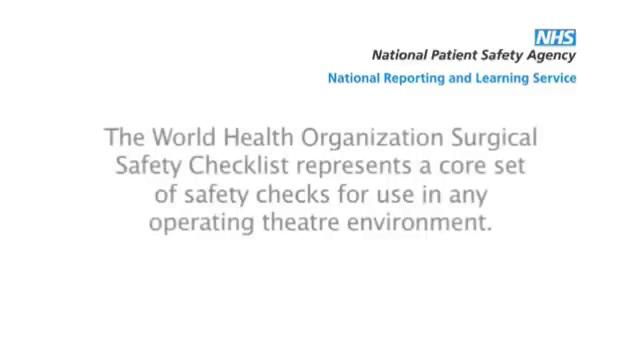

In [19]:
# show indexed videos
response = get_indexed_video_documents(AZURE_CV_ENDPOINT, AZURE_CV_KEY, VIDEO_INDEX)

indexed_videos_df = pd.DataFrame.from_records(response.json()["value"])
metadata_fields = pd.json_normalize(indexed_videos_df["metadata"])
indexed_videos_df = pd.concat([indexed_videos_df, metadata_fields], axis=1)
del indexed_videos_df["metadata"]

# Generate thumbnails and add them to the df
thumbnails = []

for url in indexed_videos_df["documentUrl"]:
    video_url = url + "?" + AZURE_SAS_TOKEN
    thumbnail = extract_frame(video_url, "00:00:10")
    thumbnails.append(image_to_html(thumbnail) if thumbnail is not None else "")

indexed_videos_df["thumbnail"] = thumbnails

# Create HTML table
html_table = indexed_videos_df[
    [
        "thumbnail",
        "filename",
        "duration_mins",
        "size_mb",
        "resolution",
        "fps",
        "createdDateTime",
        "documentUrl",
    ]
].copy()
html_table = html_table.to_html(escape=False)

display(HTML(html_table))

In [20]:
video_file = os.path.join(VIDEO_DIR, video_files[0])

print(f"Video file: {video_file}")
Video(video_file, width=640)

Video file: videos/How To Do The WHO Surgical Safety Checklist.mp4


## 4. Chat with your own video using frames & speech content

The more specific your search term is, the better tend to be the search results. 

In [21]:
def chat_with_your_own_video(query, vision_only=False):
    """
    Chat with your own video
    """
    features = ["vision"] if vision_only else ["speech", "vision"]

    search_results = find_scene(queryText=query, featureFilters=features)["value"]
    df = pd.DataFrame.from_records(search_results).head(10)
    display_tiles(df)

    return df

### Examples

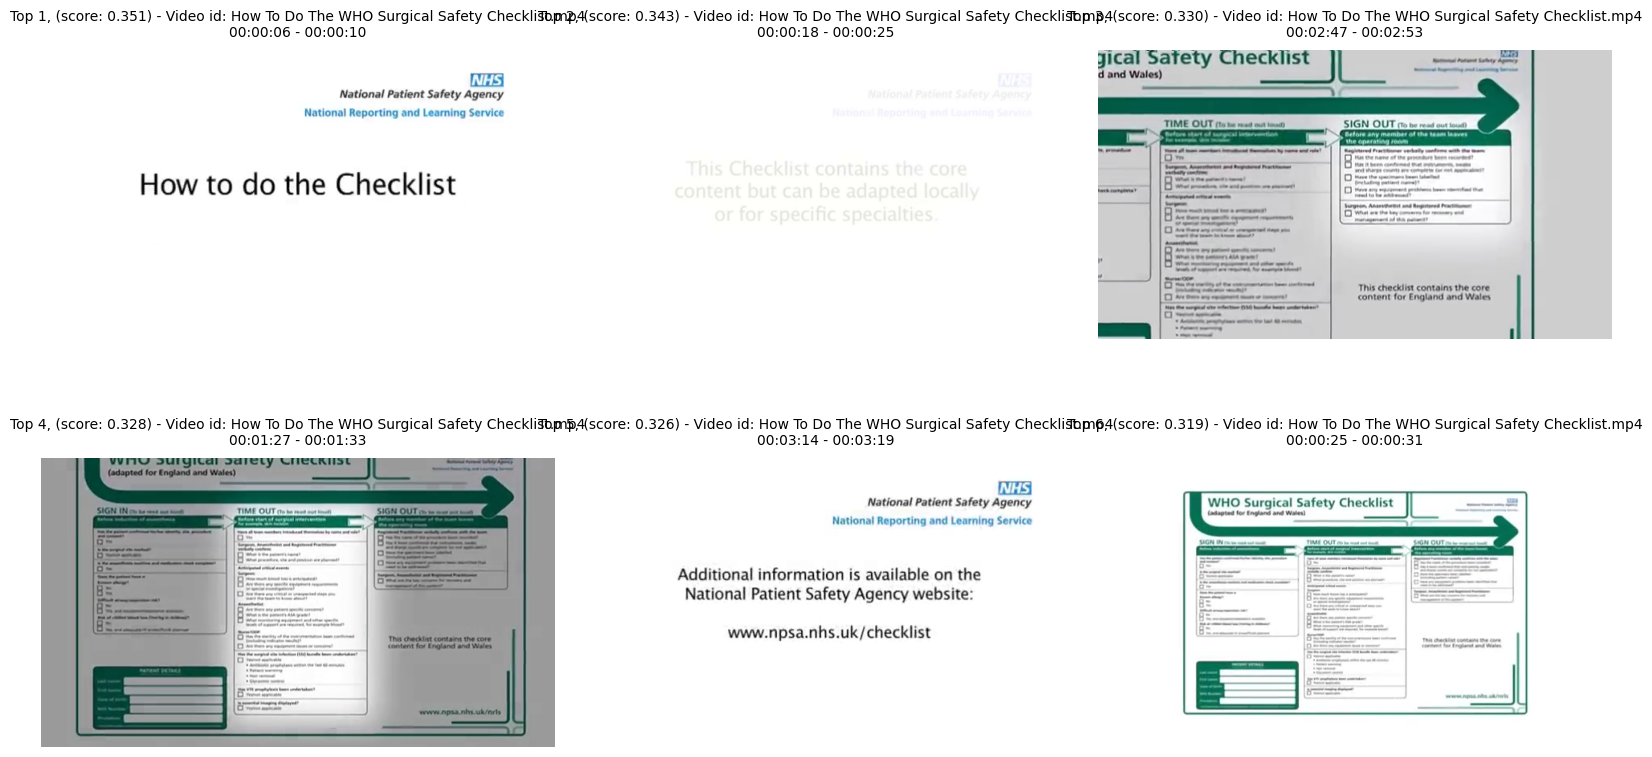

In [23]:
# search in video track only
query = "checklist"
df = chat_with_your_own_video(query, vision_only=True)

In [24]:
df

documentId   documentKind     start   
0  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:00:06  \
1  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:00:18   
2  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:02:47   
3  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:01:27   
4  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:03:14   
5  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:00:25   
6  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:00:10   
7  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:00:00   
8  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:03:24   
9  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval  00:00:51   

        end      best  relevance  
0  00:00:10  00:00:08  0.350867   
1  00:00:25  00:00:24  0.342875   
2  00:02:53  00:02:49  0.330030   
3  00:01:33  00:01:29  0.328386   
4  00:03:19  00:03:15  0.325703   
5  00:00:31  00:00:25  0.319439   
6  00:00:18  00:00:12  0.316442   
7  00:00:06  00:00:01  0.312219   
8  00:03:31  00:03:26  0.269739   
9  00:00:57  00:00:52  0.261951

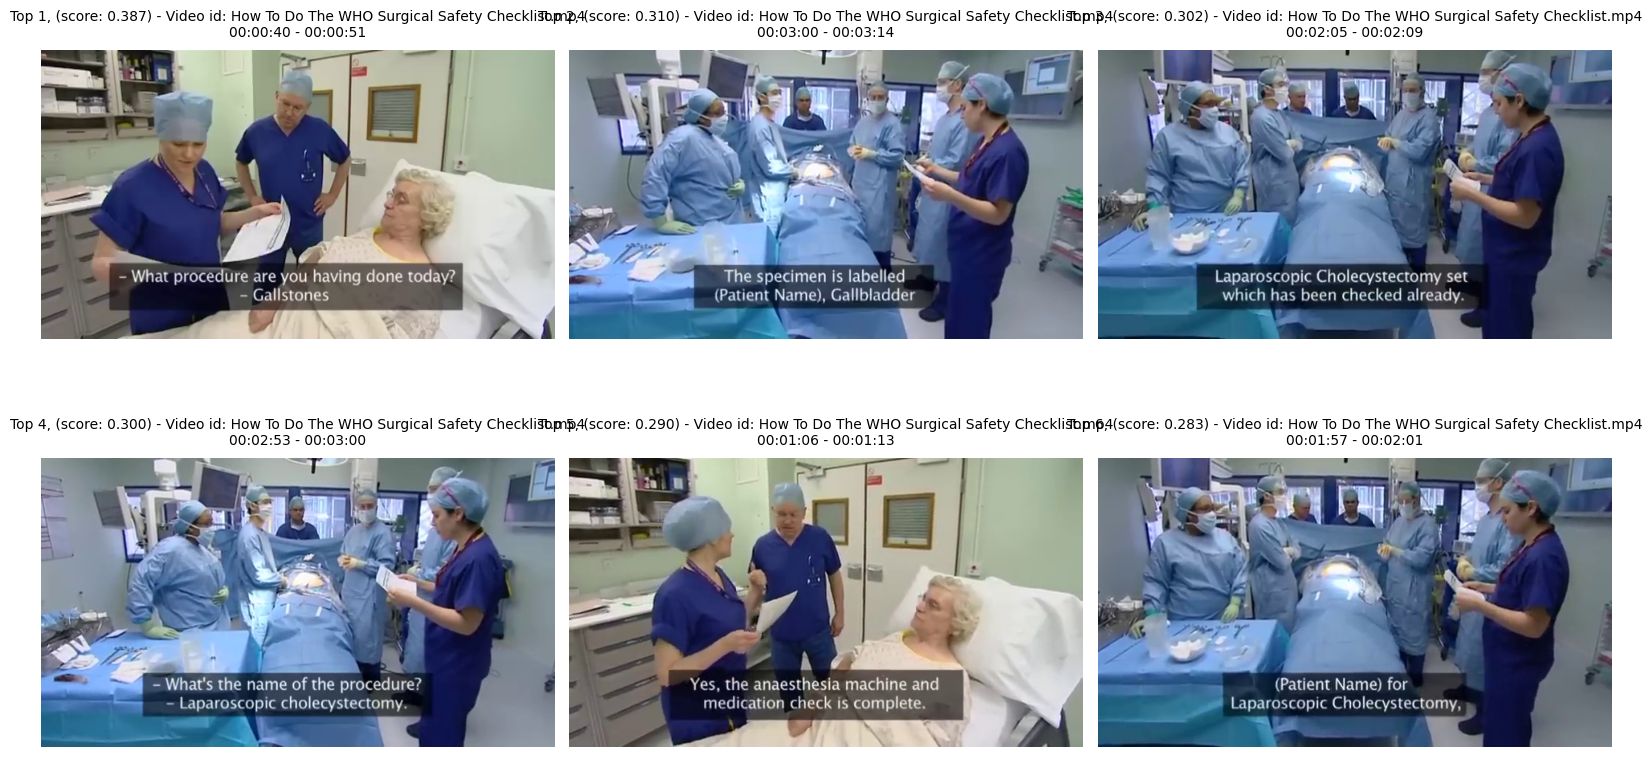

In [28]:
# search in video track only
query = "gallstones"
df = chat_with_your_own_video(query, vision_only=True)

In [27]:
df

documentId        documentKind   
0  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval       \
1  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
2  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
3  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
4  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
5  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
6  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
7  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
8  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
9  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   

              start               end              best  relevance  
0  00:00:40          00:00:51          00:00:50          0.387270   
1  00:03:00          00:03:14          00:03:03          0.309947   
2  00:02:05          00:02:09          00:02:05          0.302271   
3  00:02:53          00:03:00          00:02:57          0.299640   
4  00:01:06          00:01:13          00:01:10          0.289928   
5  00:03:01.5200000  00:03:04.3600000  00:03:03.8000000  0.284190   
6  00:01:57          00:02:01          00:01:58          0.283450   
7  00:01:54.9600000  00:02:04.6400000  00:01:56.9600000  0.274181   
8  00:01:13          00:01:27          00:01:15          0.274043   
9  00:02:05.1200000  00:02:12.6400000  00:02:05.1200000  0.273040

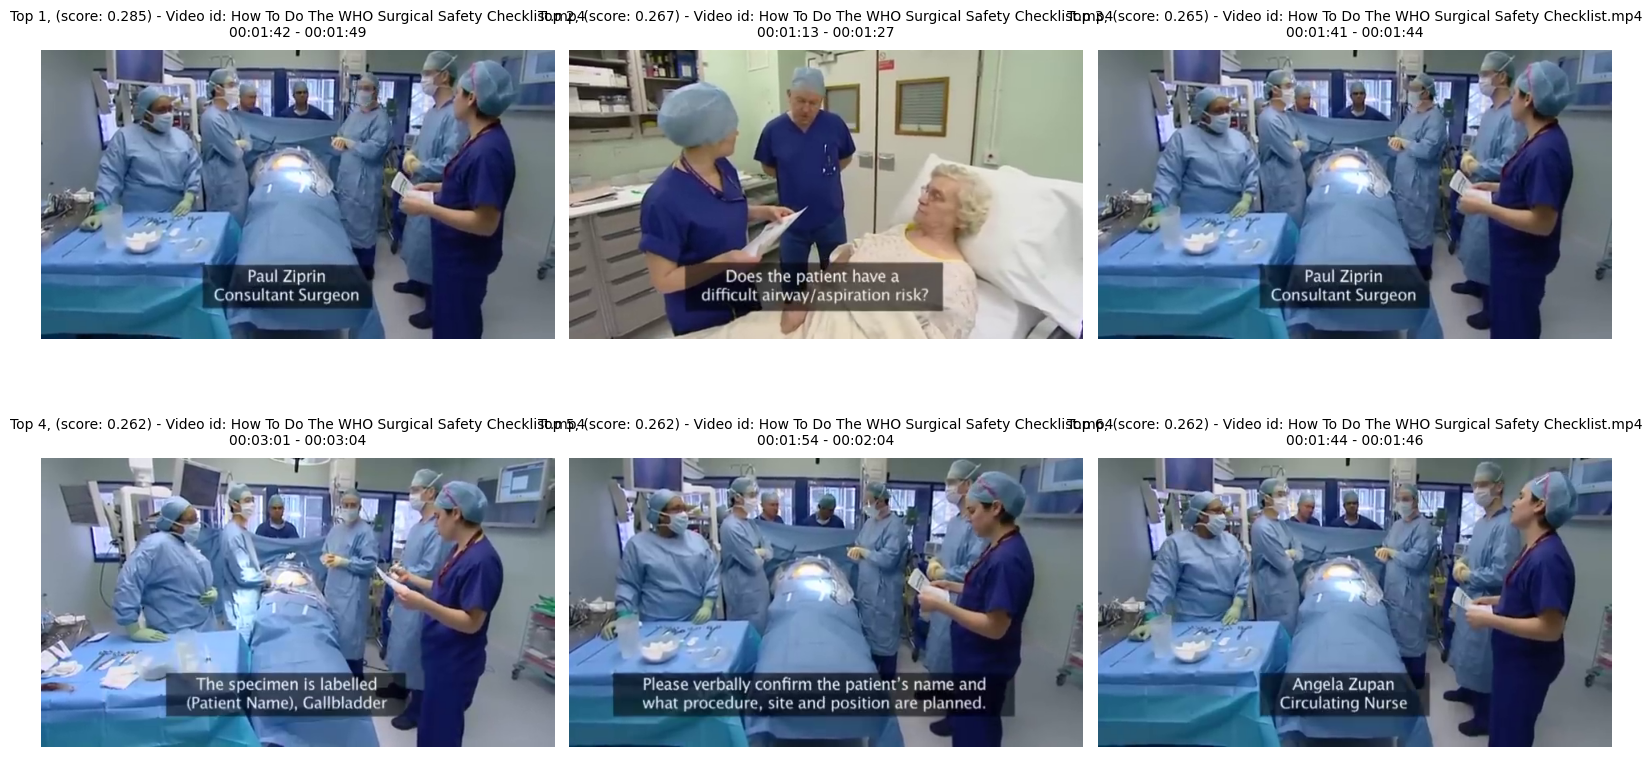

documentId        documentKind   
0  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval       \
1  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
2  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
3  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
4  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
5  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
6  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
7  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
8  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
9  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   

              start               end              best  relevance  
0  00:01:42          00:01:49          00:01:42          0.285208   
1  00:01:13          00:01:27          00:01:18          0.266736   
2  00:01:41.7600000  00:01:44.4800000  00:01:41.7600000  0.265210   
3  00:03:01.5200000  00:03:04.3600000  00:03:02.8000000  0.262498   
4  00:01:54.9600000  00:02:04.6400000  00:01:54.9600000  0.262439   
5  00:01:44.8800000  00:01:46.6000000  00:01:44.8800000  0.262136   
6  00:01:21.8000000  00:01:22.1200000  00:01:21.8000000  0.258642   
7  00:01:09.5200000  00:01:10.4400000  00:01:10.0800000  0.258554   
8  00:02:13.5600000  00:02:15.6800000  00:02:14.2000000  0.258536   
9  00:02:53.2800000  00:02:54.2000000  00:02:53.9600000  0.258215

In [29]:
query = "Ziprin"
df = chat_with_your_own_video(query, vision_only=False)
df

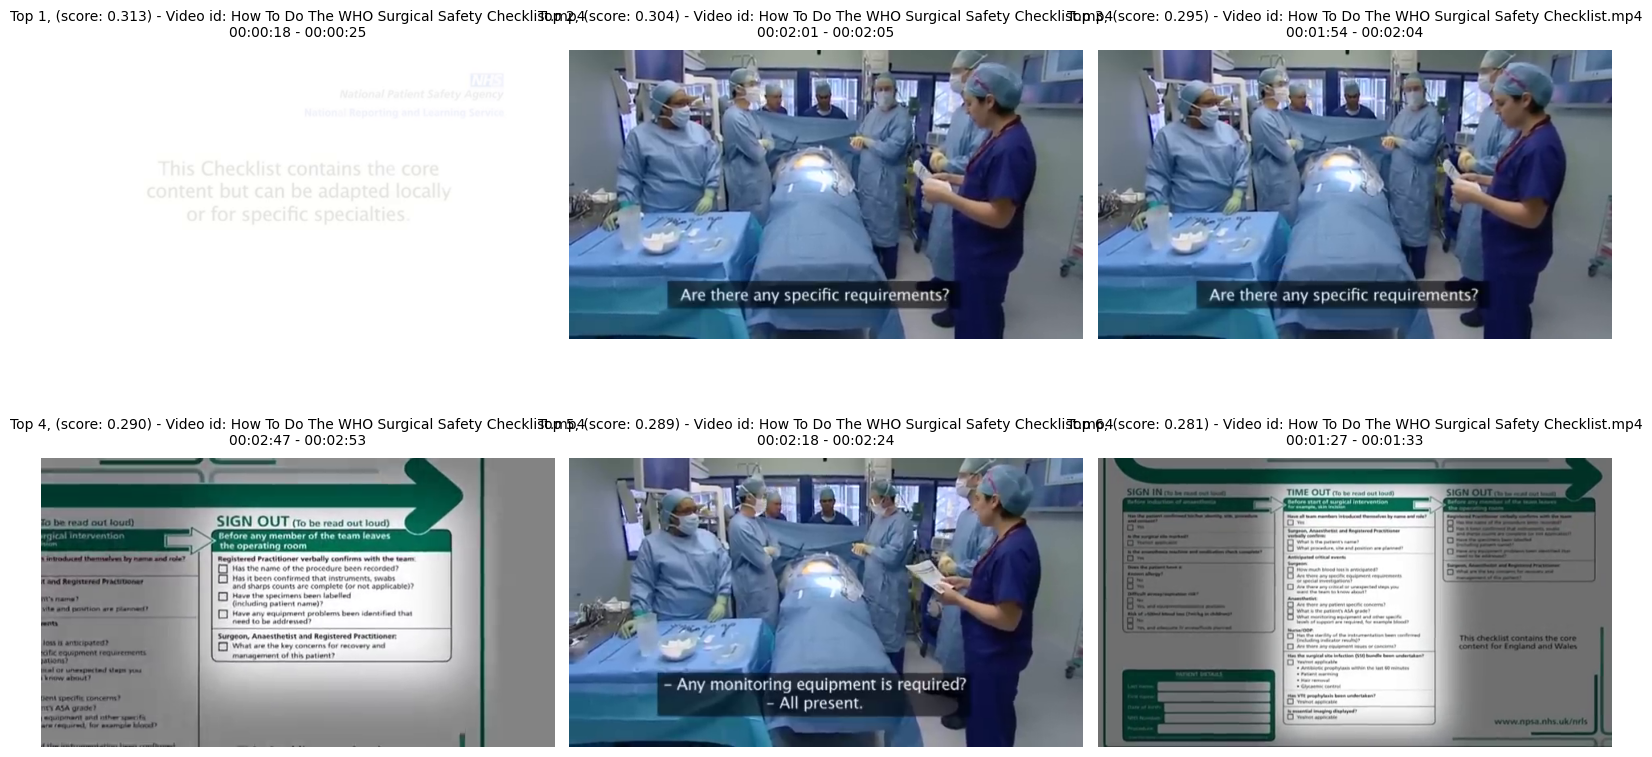

documentId        documentKind   
0  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval       \
1  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
2  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
3  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
4  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
5  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
6  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
7  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
8  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval        
9  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   

              start               end              best  relevance  
0  00:00:18          00:00:25          00:00:24          0.312610   
1  00:02:01          00:02:05          00:02:04          0.303961   
2  00:01:54.9600000  00:02:04.6400000  00:02:03.5200000  0.295498   
3  00:02:47          00:02:53          00:02:50          0.290247   
4  00:02:18          00:02:24          00:02:19          0.288826   
5  00:01:27          00:01:33          00:01:30          0.280668   
6  00:00:10          00:00:18          00:00:15          0.279244   
7  00:03:00          00:03:14          00:03:06          0.276339   
8  00:02:13          00:02:18          00:02:13          0.274874   
9  00:03:09.9200000  00:03:10.6000000  00:03:09.9200000  0.269727

In [30]:
query = "specific requirements"
df = chat_with_your_own_video(query, vision_only=False)
df

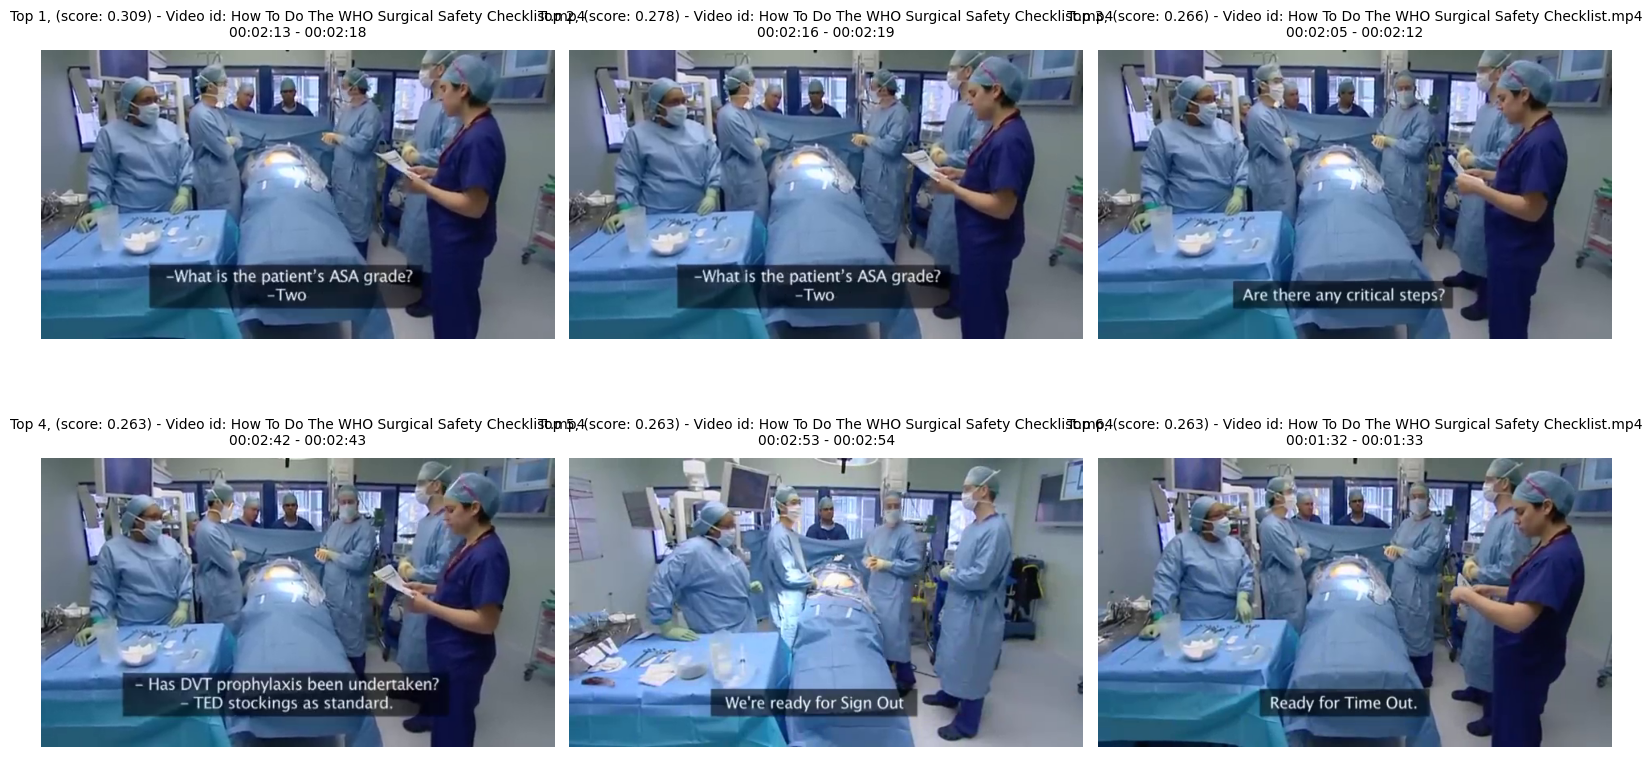

documentId        documentKind   
0  How To Do The WHO Surgical Safety Checklist.mp4  VideoInterval       \
1  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
2  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
3  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
4  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
5  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
6  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
7  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
8  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   
9  How To Do The WHO Surgical Safety Checklist.mp4  SpeechTextInterval   

              start               end              best  relevance  
0  00:02:13          00:02:18          00:02:17          0.309205   
1  00:02:16.0800000  00:02:19.8400000  00:02:16.6800000  0.277505   
2  00:02:05.1200000  00:02:12.6400000  00:02:09.2000000  0.266309   
3  00:02:42.6000000  00:02:43.6400000  00:02:43.1200000  0.262538   
4  00:02:53.2800000  00:02:54.2000000  00:02:53.9600000  0.262528   
5  00:01:32.6000000  00:01:33.4800000  00:01:33.2400000  0.262528   
6  00:02:55.2000000  00:02:57.6400000  00:02:55.2000000  0.261560   
7  00:01:09.5200000  00:01:10.4400000  00:01:10.0800000  0.261528   
8  00:00:54.4000000  00:00:59.6800000  00:00:55.4800000  0.260526   
9  00:01:22.5200000  00:01:24.6000000  00:01:22.5200000  0.260277

In [31]:
query = "ASA"
df = chat_with_your_own_video(query, vision_only=False)
df

## 5. Chat based video analysis

In [36]:
def get_results():
    for question in questions:
        display(Markdown(f"**{question}**"))
        response = video_chat(
            video_url=video_url, document_id=top_match_id, user_prompt=question
        )
        display(Markdown(response))

In [37]:
top_match_id = "How To Do The WHO Surgical Safety Checklist.mp4"

video_url = indexed_videos_df[indexed_videos_df["documentId"] == top_match_id][
    "documentUrl"
].values[0]

video_url_sas = video_url + "?" + AZURE_SAS_TOKEN

display(
    Video(
        video_url_sas, embed=False, width=800, html_attributes="controls muted autoplay"
    )
)

In [38]:
questions = [
    "Provide a summary of the video:",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    display(Markdown(response))

**Provide a summary of the video:**

The video is a demonstration of the World Health Organization Surgical Safety Checklist being used in a medical setting, adapted for England and Wales. It shows a nurse named Anna confirming the patient's identity, procedure, and consent. The patient, Joanna Davidson, is scheduled for a laparoscopic cholecystectomy with minimal expected blood loss and no known allergies. The medical team, including a consultant anaesthetist, consultant surgeon, circulating nurse, scrub nurse, surgical registrar, and anaesthetic nurse, all introduce themselves and confirm the procedure details, equipment checks, and patient care specifics such as antibiotic administration and DVT prophylaxis. The video concludes with a sign-out confirming the procedure name, correct counts, labeling of the specimen, and no equipment problems or special concerns for recovery. The video also includes acknowledgments and copyright information from the National Patient Safety Agency.

In [39]:
questions = [
    "Show a markdown table with timestamps and detailed descriptions of the scenes:",
    "Do we have any brand in the video?",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    display(Markdown(response))

**Show a markdown table with timestamps and detailed descriptions of the scenes:**

| Timestamp   | Scene Description |
|-------------|-------------------|
| 00:00:00    | Title screen displaying "World Health Organization Surgical Safety Checklist (adapted for England and Wales)" with the NHS and National Patient Safety Agency logos. |
| 00:00:06    | Transition screen with text "How to do the Checklist" under the NHS and National Patient Safety Agency logos. |
| 00:00:23    | Information screen stating "This Checklist contains the core content but can be adapted locally or for specific specialties." |
| 00:00:39    | A nurse and another healthcare professional stand beside a patient's bed, with the nurse asking the patient to confirm their name and date of birth. |
| 00:00:54    | The nurse is seen holding a document, stating the need to check that the patient has signed the consent form. |
| 00:01:02    | The nurse mentions that the surgical site is not marked because it is not applicable. |
| 00:01:14    | The nurse inquires about any known allergies from the patient, who responds with "No." |
| 00:01:30    | A view of the World Health Organization Surgical Safety Checklist board is shown with various checks and information to be filled out during the surgery process. |
| 00:01:43    | Scene in the operating room with medical staff around the patient on the operating table, and a person identified as Paul Ziprin, Consultant Surgeon. |
| 00:01:56    | A medical professional is asking for verbal confirmation of the patient's name, procedure, site, and position planned. |
| 00:02:02    | The medical team discusses the expected minimal blood loss during the procedure. |
| 00:02:09    | The team is asked about any critical steps in the procedure. |
| 00:02:21    | Confirmation of the sterility of the instrumentation is affirmed. |
| 00:02:28    | The team discusses having an open set on standby. |
| 00:02:40    | A medical professional confirms that glycemic control is not indicated for the patient. |
| 00:02:50    | The Surgical Safety Checklist board is shown again with the "SIGN OUT" section highlighted, indicating the steps to be taken before any member of the team leaves the operating room. |
| 00:03:01    | The medical team confirms that the counts for instruments, swabs, and sharps are correct. |
| 00:03:23    | Closing screen with additional sources of information listed, including websites for patient safety and safe surgery initiatives. |
| 00:03:31    | Acknowledgment screen thanking various organizations and individuals for their contributions to the video. |
| 00:03:40    | Copyright notice screen for the National Patient Safety Agency, stating the material belongs to the NPSA and authorizing its reproduction for educational and non-commercial use. |

**Do we have any brand in the video?**

Yes, there is a brand present in the video. The brand is "NHS," which stands for the National Health Service in the United Kingdom. It is visible in the images as part of the National Patient Safety Agency (NPSA) logo and the mention of the NHS website. The NHS is the publicly funded healthcare system of the UK.

In [40]:
questions = [
    "Provide a checklist from the described steps from the video",
    "Show a markdown table with timestamps and detailed descriptions of these steps:",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    display(Markdown(response))

**Provide a checklist from the described steps from the video**

Based on the video transcript and the provided images, here is a checklist of the described steps:

**Sign In (before induction of anesthesia)**
1. Confirm patient identity, site, procedure, and consent.
2. Verify the surgical site/marking.
3. Check anesthesia machine and medication.
4. Confirm patient allergies.
5. Assess airway and risk of aspiration.
6. Anticipate blood loss.

**Time Out (before start of surgical intervention)**
1. Introduce all team members by name and role.
2. Confirm patient's name and procedure.
3. Review anticipated blood loss.
4. Confirm specific requirements for laparoscopic cholecystectomy.
5. Discuss critical steps and possibility for conversion to open surgery.
6. Address any anesthetic concerns.
7. Confirm ASA grade and monitoring equipment.
8. Ensure sterility and equipment checks.
9. Confirm availability of required equipment and standby sets.
10. Administer antibiotics and other prophylaxis.
11. Confirm imaging and other specific needs.

**Sign Out (before any member of the team leaves the operating room)**
1. Confirm the name of the procedure.
2. Ensure counts are correct.
3. Label specimens appropriately.
4. Address any equipment problems.
5. Discuss key concerns for recovery and management of the patient.

**Show a markdown table with timestamps and detailed descriptions of these steps:**

| Timestamp | Description |
|-----------|-------------|
| 00:00:00  | Introduction to the World Health Organization Surgical Safety Checklist adapted for England and Wales. |
| 00:00:06  | Title screen stating "How to do the Checklist". |
| 00:00:23  | Information stating the Checklist contains core content but can be adapted locally or for specific specialties. |
| 00:00:39  | A nurse asking the patient to confirm their name and date of birth. |
| 00:00:54  | The nurse stating the need to check that the patient has signed the consent form. |
| 00:01:02  | Mention of the surgical site not being marked as it is not applicable. |
| 00:01:14  | The nurse asking the patient about any known allergies. |
| 00:01:30  | Display of the Surgical Safety Checklist with sections for "Sign In", "Time Out", and "Sign Out". |
| 00:01:43  | A consultant surgeon being introduced in the operating room. |
| 00:01:56  | Request for verbal confirmation of the patient's name, procedure, site, and position planned. |
| 00:02:02  | Discussion of expected blood loss being minimal. |
| 00:02:09  | Inquiry about any critical steps in the procedure. |
| 00:02:21  | Confirmation of the sterility of the instrumentation. |
| 00:02:28  | Mention of having an open set on standby. |
| 00:02:40  | Confirmation that glycemic control is not indicated. |
| 00:02:50  | Display of the "Sign Out" section of the Surgical Safety Checklist. |
| 00:03:01  | Confirmation that instrument, swabs, and sharps counts are complete. |
| 00:03:23  | Display of other sources of information related to patient safety and surgical procedures. |
| 00:03:31  | Acknowledgment of the organizations the NPSA would like to thank. |
| 00:03:40  | Copyright and permissions notice for the educational and non-commercial use of the material. |

In [41]:
questions = [
    "Provide a checklist from the described steps from the video in a dataframe structure with the step name,\
    the description, the starting timestamp and the ending timestamp",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    display(Markdown(response))

**Provide a checklist from the described steps from the video in a dataframe structure with the step name,    the description, the starting timestamp and the ending timestamp**

Based on the transcript provided and the images from the video, here is the checklist in a dataframe structure:

| Step Name                | Description                                                                 | Starting Timestamp | Ending Timestamp |
|--------------------------|-----------------------------------------------------------------------------|--------------------|------------------|
| Patient Identity Check   | Confirm patient identity, procedure, and consent                            | 00:00:54           | 00:01:00         |
| Consent Form Verification| Check that the consent form is signed                                       | 00:01:00           | 00:01:12         |
| Anesthesia Machine Check | Confirm anesthesia machine and medication check is complete                 | 00:01:12           | 00:01:30         |
| Allergy Check            | Confirm if the patient is allergic to anything                              | 00:01:30           | 00:01:30         |
| Time Out                 | Team introduction and confirmation of patient name, procedure, and insights | 00:02:07           | 00:02:17         |
| ASA Grade Confirmation   | Confirm patient's ASA grade                                                 | 00:02:17           | 00:02:50         |
| Sign Out                 | Confirm the name of the procedure and that the counts are correct           | 00:02:50           | 00:02:59         |
| Equipment Check          | Confirm no equipment problems                                               | 00:02:59           | 00:03:14         |
| Recovery Concerns        | Discuss key concerns for recovery                                           | 00:03:14           | 00:03:23         |

Please note that the timestamps are approximate and based on the transcript and images provided.

In [42]:
questions = [
    "Provide a checklist from the described steps from the video in a dataframe structure with the step name,\
    the description, the starting timestamp and the ending timestamp. Save the results into separate python lists",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    display(Markdown(response))

**Provide a checklist from the described steps from the video in a dataframe structure with the step name,    the description, the starting timestamp and the ending timestamp. Save the results into separate python lists**

To create the checklist from the described steps in the video, we will follow the structure of step name, description, starting timestamp, and ending timestamp. Here are the lists in Python:

```python
# Step names
step_names = [
    "Patient Identity Confirmation",
    "Consent Form Confirmation",
    "Anesthesia Machine and Medication Check",
    "Allergy Check",
    "Airway and Aspiration Risk Assessment",
    "Blood Loss Anticipation",
    "Team Introduction",
    "Procedure Confirmation",
    "Blood Loss and Specific Requirements Check",
    "Critical Steps and Concerns Addressing",
    "Equipment Check",
    "Antibiotics Administration",
    "DVT Prophylaxis and Warming Measures",
    "Final Counts and Specimen Labeling",
    "Equipment Problems Addressing",
    "Recovery Concerns Addressing"
]

# Descriptions
descriptions = [
    "Confirm patient's identity, procedure, and consent.",
    "Ensure the consent form is signed by the patient.",
    "Check that the anesthesia machine and medication check is complete.",
    "Confirm if the patient has any allergies.",
    "Assess airway difficulty and aspiration risk.",
    "Discuss the expected amount of blood loss.",
    "Each team member introduces themselves by name and role.",
    "Confirm the patient's name, procedure, and site.",
    "Check for minimal expected blood loss and specific requirements for laparoscopic cholecystectomy.",
    "Discuss the critical steps and the possibility for conversion to open surgery.",
    "Ensure all necessary surgical equipment is checked and ready.",
    "Administer the required antibiotics to the patient.",
    "Confirm DVT prophylaxis measures and patient warming.",
    "Verify that all counts are correct and the specimen is labeled correctly.",
    "Address any equipment problems encountered during the procedure.",
    "Discuss any key concerns for the patient's recovery."
]

# Starting timestamps
starting_timestamps = [
    "00:00:54",
    "00:01:00",
    "00:01:12",
    "00:01:12",
    "00:01:12",
    "00:01:12",
    "00:02:07",
    "00:02:07",
    "00:02:07",
    "00:02:07",
    "00:02:07",
    "00:02:07",
    "00:02:07",
    "00:02:59",
    "00:02:59",
    "00:02:59"
]

# Ending timestamps
ending_timestamps = [
    "00:01:00",
    "00:01:12",
    "00:01:30",
    "00:01:30",
    "00:01:30",
    "00:01:30",
    "00:02:17",
    "00:02:17",
    "00:02:17",
    "00:02:17",
    "00:02:17",
    "00:02:17",
    "00:02:17",
    "00:03:14",
    "00:03:14",
    "00:03:14"
]
```

Please note that the timestamps are approximate and based on the transcript provided. The descriptions are also summarized to fit the context of the checklist.

In [43]:
questions = [
    "Provide a checklist from the described steps from the video in a json file structure with the step name,\
    the description, the starting timestamp and the ending timestamp",
]

for question in questions:
    display(Markdown(f"**{question}**"))
    response = video_chat(
        video_url=video_url, document_id=top_match_id, user_prompt=question
    )
    display(Markdown(response))

**Provide a checklist from the described steps from the video in a json file structure with the step name,    the description, the starting timestamp and the ending timestamp**

```json
{
  "Checklist": [
    {
      "StepName": "Sign In",
      "Description": "Confirmation of patient identity, procedure, and consent; verification of surgical site; anesthesia machine and medication check; patient allergy check; airway and risk assessment; risk of blood loss assessment.",
      "StartTimestamp": "00:00:54",
      "EndTimestamp": "00:01:30"
    },
    {
      "StepName": "Time Out",
      "Description": "Team introductions; confirmation of patient name, procedure, and surgical site; review of anticipated blood loss, specific requirements, critical steps, and potential conversion to open surgery; anesthetic concerns; equipment check; antibiotic administration; DVT prophylaxis; imaging review.",
      "StartTimestamp": "00:01:30",
      "EndTimestamp": "00:02:50"
    },
    {
      "StepName": "Sign Out",
      "Description": "Confirmation of procedure name; instrument, sponge, and needle counts; specimen labeling; review of equipment problems; discussion of key concerns for recovery.",
      "StartTimestamp": "00:02:50",
      "EndTimestamp": "00:03:14"
    }
  ]
}
```

## 8. Post Processing

 We can delete our index if needed

In [44]:
index_names = get_indexes()

List of existing indexes:
['list-06feb2024-152756']


In [45]:
delete_index(index_names[0])

Deleting the index list-06feb2024-152756
Done


In [46]:
index_names = get_indexes()

List of existing indexes:
[]
